In [ ]:
# These may be needed on new environments
#!pip3 install --upgrade pip
#!pip3 install requests --upgrade
#!pip install tensorflow
#!pip install matplotlib --upgrade
#!pip install keras
#!pip install --upgrade setuptools  --ignore-installed
#!pip install tensorflow
#!pip install numpy --upgrade --ignore-installed
#!pip install sklearn --upgrade --ignore-installed

In [1]:
# Get cleaned and trusted CBS house index data from Data Hub

import requests
from requests.auth import HTTPDigestAuth
import json
import time
import pandas as pd
import urllib.parse

def getSQLResult(host, port, sql):
    try:
        sql = urllib.parse.quote(sql);
        url = 'http://' + host + ':' + port + '/v1/rows'
        header = {"Accept": "application/json"}
        #plan = 'plan=%7B%0A"$optic":%20%7B%0A"ns":%20"op",%20%0A"fn":%20"operators",%20%0A"args":%20%5B%0A%7B%0A"ns":%20"op",%20%0A"fn":%20"from-sql",%20%0A"args":%20%5B%0A"select%20*%20from%20cbs_index%20where%20year%20>%202009order%20by%20year",%20%0Anull%0A%5D%0A%7D%0A%5D%0A%7D%0A%7D'
        plan = 'plan=%7B%0A"$optic":%20%7B%0A"ns":%20"op",%20%0A"fn":%20"operators",%20%0A"args":%20%5B%0A%7B%0A"ns":%20"op",%20%0A"fn":%20"from-sql",%20%0A"args":%20%5B%0A"' + sql + '",%20%0Anull%0A%5D%0A%7D%0A%5D%0A%7D%0A%7D'

        response = (requests.get(url+"?"+plan, auth=HTTPDigestAuth('admin', 'admin'), headers=header).text)
        response = json.loads(response)
        time.sleep(0.5)
        return response
    except Exception as e:
        raise e
        
def parse_year(x):
    try:
        return x["value"]
    except Exception:
        x = 0
        return x
       
def parse_index(x):
    try:
        return x["value"]
    except Exception:
        x = 0
        return x
    
data = getSQLResult("localhost", "8011", "select * from cbs_index where year > 2009 order by year")
df = pd.DataFrame(data["rows"])
df["year"] = df["cbs_index.cbs_index.year"].apply(parse_year)
df["index"] = df["cbs_index.cbs_index.price_index"].apply(parse_index)
df

,cbs_index.cbs_index.price_index,cbs_index.cbs_index.year,year,index
0,"{'type': 'xs:decimal', 'value': -2.2}","{'type': 'xs:integer', 'value': 2010}",2010,-2.2
1,"{'type': 'xs:decimal', 'value': 2.8}","{'type': 'xs:integer', 'value': 2015}",2015,2.8
2,"{'type': 'xs:decimal', 'value': 5}","{'type': 'xs:integer', 'value': 2016}",2016,5.0
3,"{'type': 'xs:decimal', 'value': 7.6}","{'type': 'xs:integer', 'value': 2017}",2017,7.6
4,"{'type': 'xs:decimal', 'value': 9}","{'type': 'xs:integer', 'value': 2018}",2018,9.0


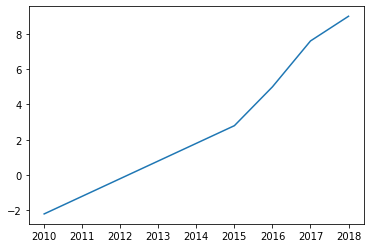

In [3]:
# Plot the CBS data in a chart
import warnings
warnings.filterwarnings(action="ignore", message=".*elementwise.*")

import matplotlib.pyplot as plt
plt.plot(df["year"], df["index"])
plt.show()

In [4]:
# Create a Linear Regression Model for the CBS data
# Plot the regression in a chart
#!pip install skl2onnx
from sklearn import datasets, linear_model

X=df['year'].values
X=X.reshape(len(X),1)
Y=df['index'].values
Y=Y.reshape(len(X),1)
model = linear_model.LinearRegression().fit(X,Y)

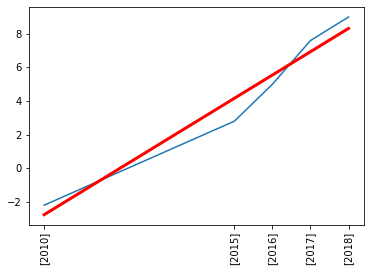

In [5]:
import warnings
warnings.filterwarnings(action="ignore", message=".*elementwise.*")

plt.plot(df["year"], df["index"])
plt.xticks(X, X, rotation='vertical')
plt.plot(X, model.predict(X), color='red',linewidth=3)
plt.show()

In [6]:
model.predict([[2019]])[0][0].round(2)

9.71

In [7]:
# Export to ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([1, 1]))]
onx = convert_sklearn(model, initial_types=initial_type, target_opset=8)

with open("CBS_Linear_Regression.onnx", "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 1.


In [8]:
# Load the ONNX and print it out

import onnx
model = onnx.load('CBS_Linear_Regression.onnx')
print(model)

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "variable"
    name: "LinearRegressor"
    op_type: "LinearRegressor"
    attribute {
      name: "coefficients"
      floats: 1.38556706905365
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: -2787.754638671875
      type: FLOATS
    }
    attribute {
      name: "targets"
      i: 1
      type: INT
    }
    domain: "ai.onnx.ml"
  }
  name: "373cab26674a41868c5b122e02616b9d"
  input {
    name: "float_input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 1
          }
        }
      }
    }
  }
  output {
    name: "variable"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            di

In [9]:
# Test the ONNX model using the ONNX runtime
import onnxruntime as rt
import numpy as np

sess = rt.InferenceSession("CBS_Linear_Regression.onnx")
input_name = sess.get_inputs()[0].name
print("input name", input_name)
label_name = sess.get_outputs()[0].name
X_test = np.array([2019])
pred_onx = sess.run([label_name], {input_name: X_test.astype(np.float32)})[0]
pred_onx[0].round(2)

input name float_input


array([9.71], dtype=float32)

In [10]:
# Store the model in MarkLogic
import requests
from requests.auth import HTTPDigestAuth

try:
    url = 'http://localhost:8011/v1/documents'
    header = {"Accept": "application/json"}
    params = 'uri=CBS_Linear_Regression.onnx'
    
    response = (requests.put(url+"?"+params, auth=HTTPDigestAuth('admin', 'admin'), headers=header, data=onx.SerializeToString()))
    print(response)
except Exception as e:
    raise e

<Response [204]>
